# <span style='color:#0099CC'> Lead Scoring Case Study

## <span style='color:#0099CC'>Problem Statement

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

In [1]:
#Supress warnings
import warnings
warnings.filterwarnings('ignore')

#importing the necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

# <span style='color:#0099CC'>Read the Data:

In [2]:
#Loading the csv file
edu_company_df_unaltered = pd.read_csv('Leads.csv')
edu_company_df_unaltered.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


#### Inspecting the dataframe

In [3]:
#Checking the shape
edu_company_df_unaltered.shape

(9240, 37)

To view the summary of the dataframe `edu_company_df_unaltered`

In [4]:
edu_company_df_unaltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

To keep the original data frame unaltered the data frame a copy of `edu_company_df_unaltered` is assigned to `edu_company_df`.

In [5]:
edu_company_df = edu_company_df_unaltered.copy()

Dropping all the sales generated columns as these columns are generated based on the lead score, hence while predicting the lead score these columns should be removed.

In [6]:
edu_company_df.drop(['Last Activity','Tags','Lead Quality','Lead Profile',
                     'Asymmetrique Activity Index','Asymmetrique Profile Index',
                     'Asymmetrique Activity Score','Asymmetrique Profile Score',
                     'Last Notable Activity'],axis = 1,inplace = True)
edu_company_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 28 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

### <span style='color:#0099CC'> Replacing `Select` value with `np.nan`

While filling the form the default option from the drop down is set to select, if the user didn't choose on of the option then the value will not be chnaged. This is not helpful for the prediction , thus **Select** value is replaced with `np.nan`.

In [7]:
# Replace the 'Select' values in the columns to np.nan
for i in edu_company_df.columns:
    # Selecting the columns which as 'Select' as one of the values
    if('Select' in edu_company_df[i].values):
        print(i)
        #Replacing with np.nan
        edu_company_df[i] = edu_company_df[i].replace('Select',np.nan)


Specialization
How did you hear about X Education
City


From the above output it is inferred that the 3 columns `Specialization` , `How did you hear about X Education
City` and `City` columns has the values '**Select**' and is replaced with np.nan.

### <span style='color:#0099CC'> Checking for null values

In [8]:
round(edu_company_df.isnull().sum()/len(edu_company_df) * 100, 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

From the output, it is clear that many columns has high missing values percentage, if these columns are imputed then the data will be altered, hence these columns are deleted from the data frame. An arbitrary percentage of 35 is choosen and columns which has missing value percentage of 35 are removed.

In [9]:
for i in edu_company_df.columns:
    a = edu_company_df[i].isnull().sum()/len(edu_company_df) * 100.00
    if(a > 35):
        print(i,":",a)
        #print(i)
        edu_company_df.drop(i,axis= 1 ,inplace =True)

Specialization : 36.58008658008658
How did you hear about X Education : 78.46320346320347
City : 39.70779220779221


### <span style='color:#0099CC'> Dropping the skewed categorical columns

Dropping the categorical columns from the DataFrame if it has more than 98% of same value.As these columns are irrelevant for the model.

In [10]:
categorical_columns = []
for i in edu_company_df.columns:
    if edu_company_df[i].dtype == 'object':
        categorical_columns.append(i)
print(categorical_columns)       

['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Country', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']


In [12]:
# Discarding the ID like columns
print('The columns which has value counts of a single value greater than 98%')
for i in categorical_columns[2:]:
    # Selecting the columns whose value counts is greater than 98
    if edu_company_df[i].value_counts()[0]/len(edu_company_df) * 100 > 98:
        print(edu_company_df[i].value_counts())

The columns which has value counts of a single value greater than 98%
No     9238
Yes       2
Name: Do Not Call, dtype: int64
No     9226
Yes      14
Name: Search, dtype: int64
No    9240
Name: Magazine, dtype: int64
No     9238
Yes       2
Name: Newspaper Article, dtype: int64
No     9239
Yes       1
Name: X Education Forums, dtype: int64
No     9239
Yes       1
Name: Newspaper, dtype: int64
No     9236
Yes       4
Name: Digital Advertisement, dtype: int64
No     9233
Yes       7
Name: Through Recommendations, dtype: int64
No    9240
Name: Receive More Updates About Our Courses, dtype: int64
No    9240
Name: Update me on Supply Chain Content, dtype: int64
No    9240
Name: Get updates on DM Content, dtype: int64
No    9240
Name: I agree to pay the amount through cheque, dtype: int64


In [11]:
# Discarding the ID like columns
print('The columns which has value counts of a single value greater than 98%')
for i in categorical_columns[2:]:
    # Selecting the columns whose value counts is greater than 98
    if edu_company_df[i].value_counts()[0]/len(edu_company_df) * 100 > 98:
        edu_company_df.drop(i,axis=1,inplace=True)
        print(i)

The columns which has value counts of a single value greater than 98%
Do Not Call
Search
Magazine
Newspaper Article
X Education Forums
Newspaper
Digital Advertisement
Through Recommendations
Receive More Updates About Our Courses
Update me on Supply Chain Content
Get updates on DM Content
I agree to pay the amount through cheque


The above columns are dropped from the DataFrame.

### <span style='color:#0099CC'> Changing the categorical column values to **Others** if it's percentage is <= 1

In [12]:
# updating the categorical columns after dropping
categorical_columns = []
for i in edu_company_df.columns:
    if edu_company_df[i].dtype == 'object':
        categorical_columns.append(i)
print(categorical_columns)

['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Country', 'What is your current occupation', 'What matters most to you in choosing a course', 'A free copy of Mastering The Interview']


In [13]:
for i in categorical_columns:
    print("======================")
    print(edu_company_df[i].value_counts()/len(edu_company_df) * 100)
    print()
    print()
    

8cd87057-136c-4ac1-9cb1-7a86cba3bfbd    0.010823
5c6e2171-cfe8-4561-9def-459f5f1197ba    0.010823
aacb019c-bcbc-4cf6-a71e-b2b93ad89bbf    0.010823
fb937984-3bf6-4f88-9b9b-14d79254ccd4    0.010823
69919b3c-59da-47ae-a337-f1fc9f989e4e    0.010823
                                          ...   
9a9d15e4-7f7e-4c1c-b04a-453081ef9957    0.010823
e5b80ec7-8531-437a-9af4-361f87733afd    0.010823
2500b781-458b-484d-8ec8-099bf279d501    0.010823
4c65ee35-aae6-4a01-8ea5-2307c3b260ed    0.010823
a2960860-76de-43b7-952f-c5f9cc705f37    0.010823
Name: Prospect ID, Length: 9240, dtype: float64


Landing Page Submission    52.878788
API                        38.744589
Lead Add Form               7.770563
Lead Import                 0.595238
Quick Add Form              0.010823
Name: Lead Origin, dtype: float64


Google               31.038961
Direct Traffic       27.521645
Olark Chat           18.993506
Organic Search       12.489177
Reference             5.779221
Welingak Website      1.536797
Refe

From the output above, it is clear that many categorical columns value counts are less than or equal to 1%(arbitrary value),these values will not have any impact while predicting and make the model complex by creating many dummy variables, thus these values are merged and named as '**Others**'.

In [13]:
for i in categorical_columns[1:]:
    print("======================")
    # Assigning the value counts to an array
    value_count_array = round(edu_company_df[i].value_counts() / len(edu_company_df) * 100,2)
    # If the categorical column has more than 3 values
    if len(value_count_array) > 3:
        # Setting a threshold of 1% , the below line will return the boolean array
        threshold = value_count_array <= 1
        # Getting the index of the value_counts less than 1%
        index_of_replacement_values = value_count_array[threshold].index
        # Creating a dictionary which is less than 1% and replacing it with value 'Others'
        replacement_dict = dict.fromkeys(index_of_replacement_values, 'Others')
        # Updating the data frame: Replacing the values in the df which are in the 
        #dictionary replacement_dict with dict value Others
        #ex : edu_company_df['Country'] = edu_company_df['Country'].replace('United States','Others') 
        edu_company_df[i] = edu_company_df[i].replace(replacement_dict) 
        print(edu_company_df[i].value_counts())
         

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Others                       56
Name: Lead Origin, dtype: int64
Google              2868
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Others                83
Name: Lead Source, dtype: int64
India     6492
Others     287
Name: Country, dtype: int64
Unemployed              5600
Working Professional     706
Student                  210
Others                    34
Name: What is your current occupation, dtype: int64


### <span style='color:#0099CC'> Dropping the rows or columns which has missing values

In [15]:
edu_company_df.isnull().sum()/len(edu_company_df) * 100

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Country                                          26.634199
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
A free copy of Mastering The Interview            0.000000
dtype: float64

In [16]:
edu_company_df.drop('What matters most to you in choosing a course',axis=1,inplace=True)

In [17]:
edu_company_df.isnull().sum()/len(edu_company_df) * 100

Prospect ID                                0.000000
Lead Number                                0.000000
Lead Origin                                0.000000
Lead Source                                0.389610
Do Not Email                               0.000000
Converted                                  0.000000
TotalVisits                                1.482684
Total Time Spent on Website                0.000000
Page Views Per Visit                       1.482684
Country                                   26.634199
What is your current occupation           29.112554
A free copy of Mastering The Interview     0.000000
dtype: float64

In [18]:
edu_company_df.drop('What is your current occupation',axis=1,inplace=True)

In [19]:
edu_company_df = edu_company_df[~edu_company_df['Country'].isna()]

In [20]:
edu_company_df.isnull().sum()/len(edu_company_df) * 100

Prospect ID                               0.000000
Lead Number                               0.000000
Lead Origin                               0.000000
Lead Source                               0.014751
Do Not Email                              0.000000
Converted                                 0.000000
TotalVisits                               0.000000
Total Time Spent on Website               0.000000
Page Views Per Visit                      0.000000
Country                                   0.000000
A free copy of Mastering The Interview    0.000000
dtype: float64

### <span style='color:#0099CC'> Imputing Null values

From the above the output, `Lead Source` column has **0.014%** of missing  values , these are replaced with the mode. 

In [21]:
impute_columns = ['Lead Source']
for i in impute_columns:
    if edu_company_df[i].dtype == object:
        edu_company_df[i].fillna(edu_company_df[i].mode()[0], inplace=True)
    else:
        edu_company_df[i].fillna(edu_company_df[i].mean(), inplace=True)

In [22]:
edu_company_df.isnull().sum()/len(edu_company_df) * 100

Prospect ID                               0.0
Lead Number                               0.0
Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Country                                   0.0
A free copy of Mastering The Interview    0.0
dtype: float64

### <span style='color:#0099CC'> Row percentage after data cleaning

In [23]:
edu_company_df.shape

(6779, 11)

In [24]:
edu_company_df_unaltered.shape

(9240, 37)

In [25]:
round(len(edu_company_df) / len(edu_company_df_unaltered) * 100,2)

73.37

**73.37%** of the rows and 11 columns are retained from the original data frame at the end of data cleaning procedure.

## <span style='color:#0099CC'>Data Exploration

#### Univariate Analysis

In [26]:
numeric_columns = []
for i in edu_company_df.columns:
    if edu_company_df[i].dtype != 'object':
        numeric_columns.append(i)

In [27]:
numeric_columns

['Lead Number',
 'Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit']

In [28]:
# To discard the Lead number and Converted columns
numeric_columns = numeric_columns[2:] 

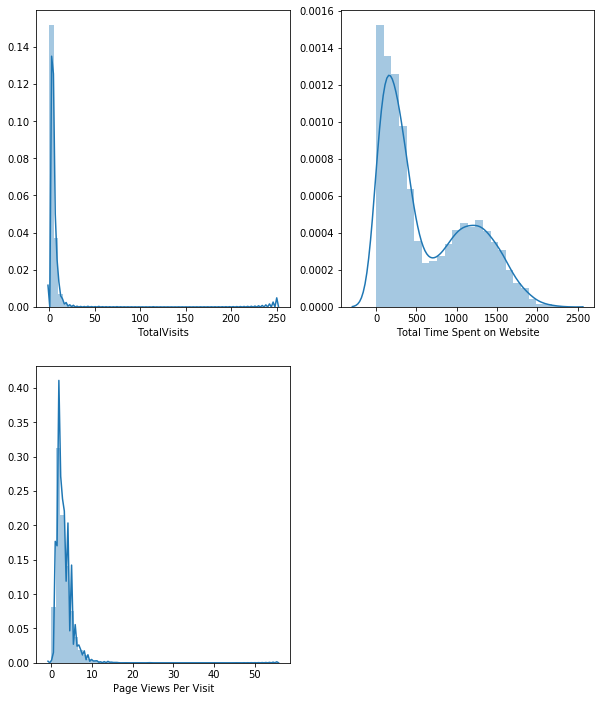

In [29]:
plt.figure(figsize=(10,12))
for i in enumerate(numeric_columns):
    plt.subplot(2,2,i[0]+1)
    sns.distplot(edu_company_df[i[1]]) 
plt.show()
        

From the above plots , it is inferred that:
* `TotalVisits`: is right skewed
* `Total Time Spent on Website` : is right skewed with a rise and fall at the end.
* `Page Views Per Visit` : is right skewed with a long tail.

Univariate analysis for categorical columns

In [30]:
edu_company_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,A free copy of Mastering The Interview
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,0,5.0,674,2.5,India,No
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,India,Yes
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,India,No
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,1,2.0,1428,1.0,India,No
6,9fae7df4-169d-489b-afe4-0f3d752542ed,660673,Landing Page Submission,Google,No,1,2.0,1640,2.0,India,No


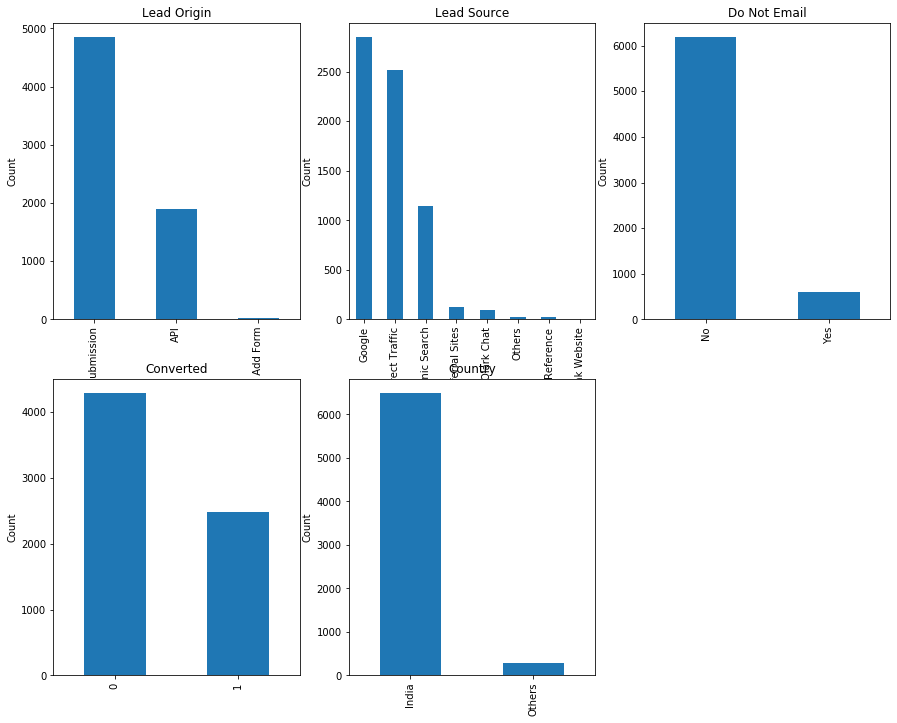

In [31]:
plt.figure(figsize=(15, 12))
plt.subplot(2,3,1)
edu_company_df['Lead Origin'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Lead Origin')
plt.subplot(2,3,2)
edu_company_df['Lead Source'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Lead Source')
plt.subplot(2,3,3)
edu_company_df['Do Not Email'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Do Not Email')
plt.subplot(2,3,4)
edu_company_df['Converted'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Converted')
plt.subplot(2,3,5)
edu_company_df['Country'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Country')
plt.show()

#### Multivariate Analysis

In [32]:
# x

# <span style='color:#0099CC'>Outliers

In [33]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
edu_company_df.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000
mean,617571.591975,0.366573,4.553917,631.898658,3.126197
std,23636.201519,0.481904,5.138148,542.115855,1.958933
min,579533.000000,0.000000,0.000000,0.000000,0.000000
25%,596564.500000,0.000000,2.000000,171.000000,2.000000
50%,616049.000000,0.000000,4.000000,397.000000,3.000000
75%,637959.500000,1.000000,5.000000,1105.500000,4.000000
90%,651281.600000,1.000000,8.000000,1452.000000,5.000000
95%,655739.000000,1.000000,11.000000,1606.000000,7.000000
99%,659687.420000,1.000000,18.220000,1863.660000,10.000000


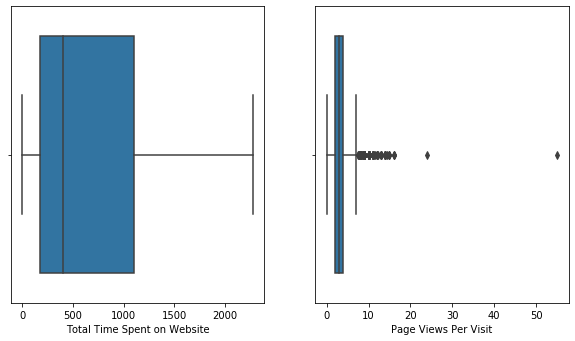

In [34]:
plt.figure(figsize=(10,12))
for i in enumerate(numeric_columns[1:]):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(edu_company_df[i[1]]) 
plt.show()

From the above outputs it is inferred that the columns `TotalVisits` and `Page Views Per Visit` have outliers and these are removed.

In [35]:
Q1 = edu_company_df.TotalVisits.quantile(0.05)
Q3 = edu_company_df.TotalVisits.quantile(0.95)
IQR = Q3 - Q1
# Removing the rows where the column based on TotalVisits value
edu_company_df = edu_company_df[(edu_company_df.TotalVisits >= Q1 - 1.5*IQR) 
                                & (edu_company_df.TotalVisits <= Q3 + 1.5*IQR)]




In [36]:
Q1 = edu_company_df['Page Views Per Visit'].quantile(0.05)
Q3 = edu_company_df['Page Views Per Visit'].quantile(0.95)
IQR = Q3 - Q1
# Removing the rows where the column based on Page Views Per Visit value
edu_company_df = edu_company_df[(edu_company_df['Page Views Per Visit'] >= Q1 - 1.5*IQR) 
                                & (edu_company_df['Page Views Per Visit'] <= Q3 + 1.5*IQR)]




In [37]:
edu_company_df.shape

(6751, 11)

In [38]:
round(len(edu_company_df) / len(edu_company_df_unaltered) * 100,2)

73.06

# <span style='color:#0099CC'> Data Preparation

### <span style='color:#0099CC'>Dropping the ID-like columns

As these columns have unique value for each row in the data set which is irrelevant in predictive modelling , thus these columns are dropped. After having a close look , it is inferred that columns `Prospect ID` and `Lead Number` are dropped from the DataFrame.

In [39]:
edu_company_df= edu_company_df.drop(['Prospect ID','Lead Number'],axis =1)
edu_company_df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,A free copy of Mastering The Interview
1,API,Organic Search,No,0,5.0,674,2.5,India,No
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,India,Yes
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,India,No
4,Landing Page Submission,Google,No,1,2.0,1428,1.0,India,No
6,Landing Page Submission,Google,No,1,2.0,1640,2.0,India,No


### <span style='color:#0099CC'>Creating dummy variables

#### Converting some binary variables (Yes/No) to 0/1

Converting the categorical columns values which has 2 values i.e., `Yes` and `No` to 1 and 0 respectively. 

In [40]:
# Creating an array which has yes no values
varlist = []
for i in edu_company_df.columns:
    if edu_company_df[i].dtype == 'object':
        if edu_company_df[i].nunique() == 2:
            if('No' in edu_company_df[i].values and 'Yes' in edu_company_df[i].values):
                varlist.append(i)


In [41]:
varlist

['Do Not Email', 'A free copy of Mastering The Interview']

In [42]:
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
edu_company_df[varlist] = edu_company_df[varlist].apply(binary_map)

In [43]:
edu_company_df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,A free copy of Mastering The Interview
1,API,Organic Search,0,0,5.0,674,2.5,India,0
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,India,1
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,India,0
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,India,0
6,Landing Page Submission,Google,0,1,2.0,1640,2.0,India,0


### <span style='color:#0099CC'>one-hot encodeding

For categorical variables with multiple levels and for 2 levels with different values(other than Yes and No),  dummy variables are created

In [44]:
# Replace the 'Select' values in the columns to np.nan
multiple_level_varlist = []
for i in edu_company_df.columns:
    if edu_company_df[i].dtype == 'object':
        if edu_company_df[i].nunique() >= 2:
                multiple_level_varlist.append(i)
multiple_level_varlist

['Lead Origin', 'Lead Source', 'Country']

In [45]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(edu_company_df[multiple_level_varlist])

#Removing the columns that has others
f = dummy1.columns
for i in f:    
    if ('Others' in i):
        dummy1.drop(i,axis = 1,inplace = True)

# Adding the results to the master dataframe
edu_company_df = pd.concat([edu_company_df, dummy1], axis=1)


#### Dropping the repeated variables

Dropping the orginal columns after creating dummies for those columns.

In [46]:
multiple_level_varlist

['Lead Origin', 'Lead Source', 'Country']

In [47]:
edu_company_df.drop(multiple_level_varlist, axis=1, inplace=True)

In [48]:
edu_company_df.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Country_India
1,0,0,5.0,674,2.5,0,1,0,0,0,0,0,1,0,0,0,1
2,0,1,2.0,1532,2.0,1,0,1,0,1,0,0,0,0,0,0,1
3,0,0,1.0,305,1.0,0,0,1,0,1,0,0,0,0,0,0,1
4,0,1,2.0,1428,1.0,0,0,1,0,0,1,0,0,0,0,0,1
6,0,1,2.0,1640,2.0,0,0,1,0,0,1,0,0,0,0,0,1


### <span style='color:#0099CC'> To check the imbalance in the data set

In [49]:
### Checking the data imbalance
converted_data = round((sum(edu_company_df['Converted'])/len(edu_company_df['Converted'].index))*100,2)
converted_data

36.72

**36.72%** of the rows are Convereted. Since the data set is not heavily imbalanced, logistic regression can be performed.

## Looking at Correlations

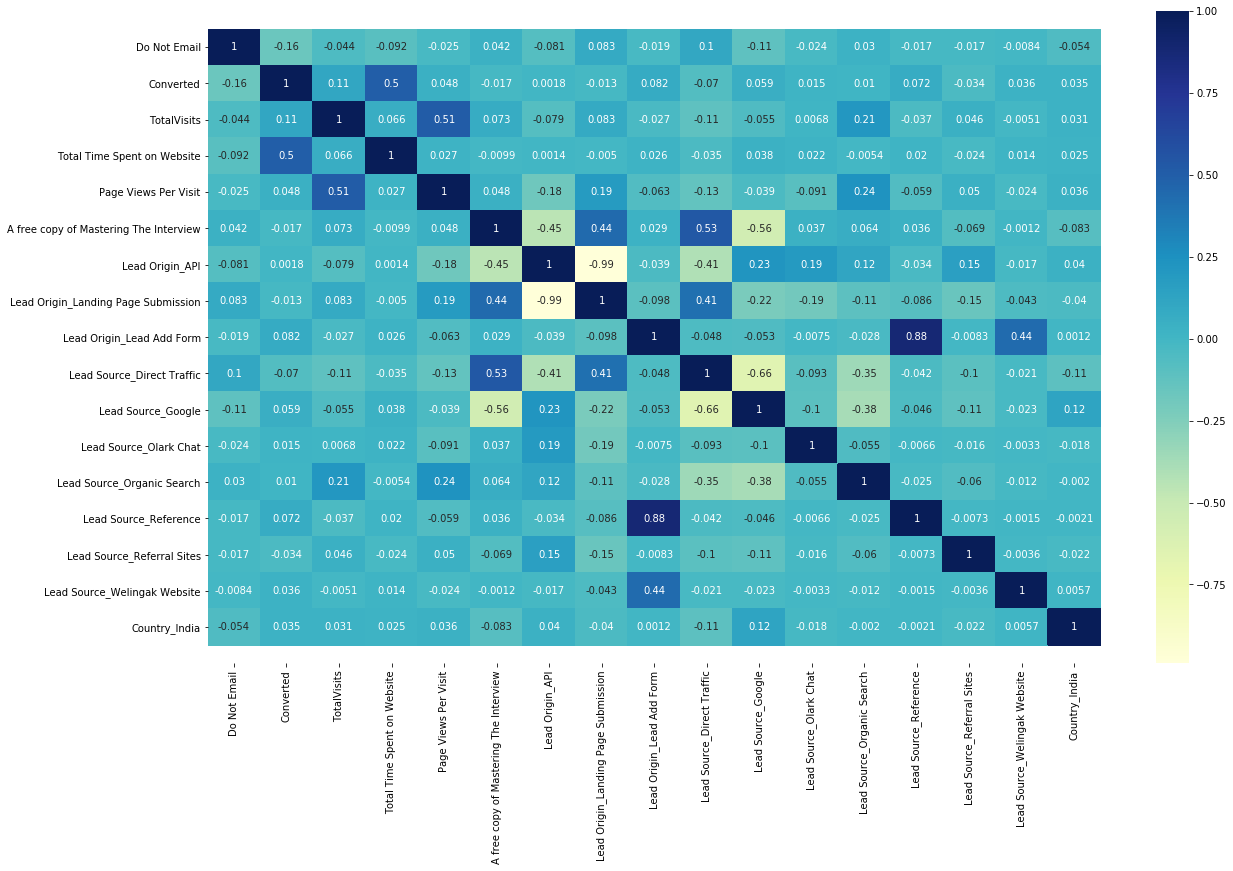

In [50]:
plt.figure(figsize=(20,12))
ax = sns.heatmap(edu_company_df.corr(), annot=True,cmap='YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

From the above output we can infer that there is strong correlation between 
* `Lead Origin_Landing Page Submission` and `Lead Origin_API`
* `Lead Source_Reference` and `Lead Origin_Lead Add Form` <br/>
hence we can drop one of the variable because it will be redundant and make the model complex.

In [51]:
edu_company_df = edu_company_df.drop(['Lead Origin_Landing Page Submission','Lead Source_Reference'],axis =1)
edu_company_df.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Referral Sites,Lead Source_Welingak Website,Country_India
1,0,0,5.0,674,2.5,0,1,0,0,0,0,1,0,0,1
2,0,1,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,1
3,0,0,1.0,305,1.0,0,0,0,1,0,0,0,0,0,1
4,0,1,2.0,1428,1.0,0,0,0,0,1,0,0,0,0,1
6,0,1,2.0,1640,2.0,0,0,0,0,1,0,0,0,0,1


### <span style='color:#0099CC'> Splitting the data into Training and Testing Sets

Dropping the target variable and assigning to `X`.

In [52]:
X = edu_company_df.drop(['Converted'],axis =1)
X.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Referral Sites,Lead Source_Welingak Website,Country_India
1,0,5.0,674,2.5,0,1,0,0,0,0,1,0,0,1
2,0,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,1
3,0,1.0,305,1.0,0,0,0,1,0,0,0,0,0,1
4,0,2.0,1428,1.0,0,0,0,0,1,0,0,0,0,1
6,0,2.0,1640,2.0,0,0,0,0,1,0,0,0,0,1


The target variable is assigned to a variable `y`.

In [53]:
y = edu_company_df['Converted']
y.head()

1    0
2    1
3    0
4    1
6    1
Name: Converted, dtype: int64

In [54]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [55]:
print("Shape of X_Train",X_train.shape)
print("Shape of X_Test",X_test.shape)
print("Shape of original dataframe (edu_company_df)",edu_company_df.shape)

Shape of X_Train (5400, 14)
Shape of X_Test (1351, 14)
Shape of original dataframe (edu_company_df) (6751, 15)


In [56]:
print("Shape of y_Train",y_train.shape)
print("Shape of y_Test",y_test.shape)
print("Shape of original dataframe (edu_company_df)",edu_company_df.shape)

Shape of y_Train (5400,)
Shape of y_Test (1351,)
Shape of original dataframe (edu_company_df) (6751, 15)


In [57]:
y_test

987     0
4907    0
8742    1
3864    0
444     0
       ..
7198    0
431     0
1357    0
1031    0
7093    0
Name: Converted, Length: 1351, dtype: int64

### <span style='color:#0099CC'>Scaling the varibles

For easy interpretation and optimisation of the model, the numerical variables in the data set which have unique values other than 0 and 1 are scaled using **Standard scaling**.

In [58]:
X.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Referral Sites,Lead Source_Welingak Website,Country_India
1,0,5.0,674,2.5,0,1,0,0,0,0,1,0,0,1
2,0,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,1
3,0,1.0,305,1.0,0,0,0,1,0,0,0,0,0,1
4,0,2.0,1428,1.0,0,0,0,0,1,0,0,0,0,1
6,0,2.0,1640,2.0,0,0,0,0,1,0,0,0,0,1


In [59]:
continuous_columns = []
for i in X.columns:
    if X[i].dtype == 'int' or X[i].dtype == 'float':
        if X[i].nunique() > 2:
            continuous_columns.append(i)
continuous_columns
            

['TotalVisits', 'Page Views Per Visit']

In [60]:
scaling_edu_company_df = StandardScaler()
X_train[continuous_columns] = scaling_edu_company_df.fit_transform(X_train[continuous_columns])
X_train[continuous_columns]

,TotalVisits,Page Views Per Visit
4581,-0.761628,-0.612639
5109,-0.761628,-0.612639
4524,1.507946,-0.471361
6838,-0.113179,0.517583
7760,0.859496,-0.426152
...,...,...
8284,0.535271,-0.047528
98,0.211046,1.082694
5303,0.535271,-0.047528
8179,6.371319,2.778028


## <span style='color:#0099CC'>Model Building

### <span style="color:#0099cc"> Building the Logistic Regression model using RFE (Recursive Feature Elimination)

In [61]:
X.shape

(6751, 14)

In [62]:
logreg = LogisticRegression()
rfe = RFE(logreg, 12)             # running RFE with 12 variables as output
rfe = rfe.fit(X_train, y_train)

RFE provides `rfe.support_` which will give the information about the variables, whether it is selected or not. The Rank 1 is given for the variables that are selected.

In [63]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', False, 3),
 ('Page Views Per Visit', False, 2),
 ('A free copy of Mastering The Interview', True, 1),
 ('Lead Origin_API', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', True, 1),
 ('Lead Source_Referral Sites', True, 1),
 ('Lead Source_Welingak Website', True, 1),
 ('Country_India', True, 1)]

In [64]:
cols = X_train.columns[rfe.support_]
print(cols)

Index(['Do Not Email', 'TotalVisits', 'A free copy of Mastering The Interview',
       'Lead Origin_API', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Country_India'],
      dtype='object')


Among the 14 columns , using the RFE method, the top 12 variables are selected.

In [65]:
# Creating a new X_train dataframe with RFE selected variables
X_train_1 = sm.add_constant(X_train[cols])
logm1 = sm.GLM(y_train,X_train_1, family = sm.families.Binomial())
model_1 = logm1.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5400
Model:                            GLM   Df Residuals:                     5387
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3404.9
Date:                Fri, 18 Dec 2020   Deviance:                       6809.8
Time:                        18:18:43   Pearson chi2:                 5.35e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.8138      0.781     -2.323      0.020      -3.344      -0.284
Do Not Email                              -1.5750      0.153    -10.295      0.000      -1.875      -1.275
TotalVisits                                0.2146      0.030      7.143      0.000       0.156       0.273
A free copy of Mastering The Interview     0.0675      0.080      0.840      0.401      -0.090       0.225
Lead Origin_API                           -0.0376      0.076     -0.494      0.621      -0.187       0.112
Lead Origin_Lead Add Form                 25.2519   1.91e+04      0.001      0.999   -3.73e+04    3.74e+04
Lead Source_Direct Traffic                 0.9844      0.769      1.281      0.200      -0.522       2.491
Lead Source_Google                         1.2879      0.767      1.678      0.093      -0.216       2.792
Lead Source_Olark Chat                     1.4986      0.805      1.862      0.063      -0.079       3.076
Lead Source_Organic Search                 1.1588      0.770      1.505      0.132      -0.350       2.668
Lead Source_Referral Sites                 0.4289      0.804      0.533      0.594      -1.148       2.005
Lead Source_Welingak Website              -0.0591   3.97e+04  -1.49e-06      1.000   -7.78e+04    7.78e+04
Country_India                              0.2079      0.157      1.327      0.185      -0.099       0.515
==========================================================================================================
"""

In [66]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,Country_India,23.12
6,Lead Source_Google,11.50
5,Lead Source_Direct Traffic,10.53
8,Lead Source_Organic Search,5.53
2,A free copy of Mastering The Interview,3.12
3,Lead Origin_API,2.02
9,Lead Source_Referral Sites,1.48
7,Lead Source_Olark Chat,1.45
4,Lead Origin_Lead Add Form,1.40
10,Lead Source_Welingak Website,1.29


From the above output, it is clear that the 9 variables have a p-value > 0.05
* Among these 9 variables `Lead Source_Welingak Website` has a p-value of 1, hence we need to drop this column first and rerun the model again.

In [67]:
# Dropping the column
cols = cols.drop('Lead Source_Welingak Website', 1)
cols

Index(['Do Not Email', 'TotalVisits', 'A free copy of Mastering The Interview',
       'Lead Origin_API', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites', 'Country_India'],
      dtype='object')

### <span style='color:#006699'>The model is build again after dropping the column `Lead Source_Welingak Website`.

In [68]:
X_train_2 = sm.add_constant(X_train[cols])
logm2 = sm.GLM(y_train,X_train_2, family = sm.families.Binomial())
model_2 = logm2.fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5400
Model:                            GLM   Df Residuals:                     5388
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3404.9
Date:                Fri, 18 Dec 2020   Deviance:                       6809.8
Time:                        18:18:43   Pearson chi2:                 5.35e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.8138      0.781     -2.323      0.020      -3.344      -0.284
Do Not Email                              -1.5750      0.153    -10.295      0.000      -1.875      -1.275
TotalVisits                                0.2146      0.030      7.143      0.000       0.156       0.273
A free copy of Mastering The Interview     0.0675      0.080      0.840      0.401      -0.090       0.225
Lead Origin_API                           -0.0376      0.076     -0.494      0.621      -0.187       0.112
Lead Origin_Lead Add Form                 25.2384   1.67e+04      0.002      0.999   -3.27e+04    3.28e+04
Lead Source_Direct Traffic                 0.9844      0.769      1.281      0.200      -0.522       2.491
Lead Source_Google                         1.2879      0.767      1.678      0.093      -0.216       2.792
Lead Source_Olark Chat                     1.4986      0.805      1.862      0.063      -0.079       3.076
Lead Source_Organic Search                 1.1588      0.770      1.505      0.132      -0.350       2.668
Lead Source_Referral Sites                 0.4289      0.804      0.533      0.594      -1.148       2.005
Country_India                              0.2079      0.157      1.327      0.185      -0.099       0.515
==========================================================================================================
"""

In [69]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,Country_India,23.12
6,Lead Source_Google,11.50
5,Lead Source_Direct Traffic,10.53
8,Lead Source_Organic Search,5.53
2,A free copy of Mastering The Interview,3.12
3,Lead Origin_API,2.02
9,Lead Source_Referral Sites,1.48
7,Lead Source_Olark Chat,1.45
0,Do Not Email,1.12
4,Lead Origin_Lead Add Form,1.10


* Among the 8 columns which has p-value > 0.05 , `Lead Origin_Lead Add Form` has highest p-value of 0.999. This column is dropped and the model is build again.

In [70]:
cols = cols.drop('Lead Origin_Lead Add Form', 1)
cols

Index(['Do Not Email', 'TotalVisits', 'A free copy of Mastering The Interview',
       'Lead Origin_API', 'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites', 'Country_India'],
      dtype='object')

### <span style='color:#006699'> The model is build again after dropping the column `Lead Origin_Lead Add Form`.

In [71]:
X_train_3 = sm.add_constant(X_train[cols])
logm3 = sm.GLM(y_train,X_train_3, family = sm.families.Binomial())
model_3 = logm3.fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5400
Model:                            GLM   Df Residuals:                     5389
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3421.3
Date:                Fri, 18 Dec 2020   Deviance:                       6842.5
Time:                        18:18:43   Pearson chi2:                 5.37e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.5927      0.384      1.542      0.123      -0.160       1.346
Do Not Email                              -1.5978      0.153    -10.425      0.000      -1.898      -1.297
TotalVisits                                0.2109      0.030      7.048      0.000       0.152       0.270
A free copy of Mastering The Interview     0.0795      0.080      0.993      0.321      -0.077       0.236
Lead Origin_API                           -0.0455      0.076     -0.599      0.549      -0.195       0.104
Lead Source_Direct Traffic                -1.4333      0.356     -4.029      0.000      -2.131      -0.736
Lead Source_Google                        -1.1196      0.356     -3.147      0.002      -1.817      -0.422
Lead Source_Olark Chat                    -0.9098      0.430     -2.114      0.034      -1.753      -0.066
Lead Source_Organic Search                -1.2506      0.360     -3.472      0.001      -1.957      -0.545
Lead Source_Referral Sites                -1.9745      0.430     -4.588      0.000      -2.818      -1.131
Country_India                              0.2112      0.156      1.352      0.176      -0.095       0.517
==========================================================================================================
"""

In [72]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,Country_India,21.23
5,Lead Source_Google,10.62
4,Lead Source_Direct Traffic,9.67
7,Lead Source_Organic Search,5.15
2,A free copy of Mastering The Interview,3.09
3,Lead Origin_API,2.02
8,Lead Source_Referral Sites,1.45
6,Lead Source_Olark Chat,1.42
0,Do Not Email,1.12
1,TotalVisits,1.08


In [73]:
cols = cols.drop('Country_India', 1)
cols

Index(['Do Not Email', 'TotalVisits', 'A free copy of Mastering The Interview',
       'Lead Origin_API', 'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites'],
      dtype='object')

### <span style='color:#006699'> Rerun the model after dropping the column `Country_India`.

In [74]:
X_train_4 = sm.add_constant(X_train[cols])
logm4 = sm.GLM(y_train,X_train_4, family = sm.families.Binomial())
model_4 = logm4.fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5400
Model:                            GLM   Df Residuals:                     5390
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3422.2
Date:                Fri, 18 Dec 2020   Deviance:                       6844.4
Time:                        18:18:43   Pearson chi2:                 5.38e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.7946      0.354      2.243      0.025       0.100       1.489
Do Not Email                              -1.6031      0.153    -10.463      0.000      -1.903      -1.303
TotalVisits                                0.2123      0.030      7.101      0.000       0.154       0.271
A free copy of Mastering The Interview     0.0764      0.080      0.955      0.340      -0.080       0.233
Lead Origin_API                           -0.0466      0.076     -0.613      0.540      -0.196       0.102
Lead Source_Direct Traffic                -1.4344      0.356     -4.031      0.000      -2.132      -0.737
Lead Source_Google                        -1.1125      0.356     -3.127      0.002      -1.810      -0.415
Lead Source_Olark Chat                    -0.9091      0.430     -2.113      0.035      -1.753      -0.066
Lead Source_Organic Search                -1.2479      0.360     -3.464      0.001      -1.954      -0.542
Lead Source_Referral Sites                -1.9768      0.430     -4.594      0.000      -2.820      -1.133
==========================================================================================================
"""

In [75]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,A free copy of Mastering The Interview,3.09
4,Lead Source_Direct Traffic,2.77
3,Lead Origin_API,2.02
7,Lead Source_Organic Search,1.77
5,Lead Source_Google,1.60
6,Lead Source_Olark Chat,1.16
0,Do Not Email,1.12
8,Lead Source_Referral Sites,1.11
1,TotalVisits,1.08


The column `A free copy of Mastering The Interview` as a highest p-value of **0.205** > 0.05, thus it is dropped.

In [76]:
cols = cols.drop('A free copy of Mastering The Interview', 1)
cols

Index(['Do Not Email', 'TotalVisits', 'Lead Origin_API',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites'],
      dtype='object')

### <span style='color:#006699'> Rerun the model after dropping the column `A free copy of Mastering The Interview`.

In [77]:
X_train_5 = sm.add_constant(X_train[cols])
logm5 = sm.GLM(y_train,X_train_5, family = sm.families.Binomial())
model_5 = logm5.fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5400
Model:                            GLM   Df Residuals:                     5391
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3422.6
Date:                Fri, 18 Dec 2020   Deviance:                       6845.3
Time:                        18:18:43   Pearson chi2:                 5.38e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.8334      0.352      2.367      0.018       0.143       1.524
Do Not Email                  -1.6067      0.153    -10.492      0.000      -1.907      -1.307
TotalVisits                    0.2136      0.030      7.152      0.000       0.155       0.272
Lead Origin_API               -0.0709      0.072     -0.990      0.322      -0.211       0.070
Lead Source_Direct Traffic    -1.4127      0.355     -3.977      0.000      -2.109      -0.716
Lead Source_Google            -1.1346      0.355     -3.194      0.001      -1.831      -0.438
Lead Source_Olark Chat        -0.8810      0.429     -2.052      0.040      -1.723      -0.039
Lead Source_Organic Search    -1.2395      0.360     -3.440      0.001      -1.946      -0.533
Lead Source_Referral Sites    -1.9833      0.430     -4.608      0.000      -2.827      -1.140
==============================================================================================
"""

In [78]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Lead Origin_API,1.80
4,Lead Source_Google,1.44
6,Lead Source_Organic Search,1.28
0,Do Not Email,1.12
5,Lead Source_Olark Chat,1.09
1,TotalVisits,1.08
3,Lead Source_Direct Traffic,1.08
7,Lead Source_Referral Sites,1.08


All the columns have a p-value less than 0.05 and VIF value less than 5.Thus we need not drop any more variables and we can proceed with making predictions as the model build using these variables is reliable.

### <span style='color:#0099CC'> Predictions on the trained data set

In [79]:
# Getting the predicted values on the train set
y_train_pred = model_5.predict(X_train_5)
y_train_pred.head()

4581    0.095667
5109    0.322580
4524    0.479031
6838    0.419389
7760    0.402359
dtype: float64

In [80]:
y_train_pred.shape

(5400,)

Converting to a single dimensional array so that we can add this array as a column to the data frame.

In [81]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.09566652, 0.32258008, 0.47903133, 0.41938877, 0.40235946,
       0.35343245, 0.30763501, 0.2358358 , 0.32258008, 0.33789685])

In [82]:
y_train_pred.shape

(5400,)

##### Creating a dataframe with the actual converted value and the predicted probabilities

In [83]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['Index_ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Index_ID
0,1,0.095667,4581
1,0,0.322580,5109
2,0,0.479031,4524
3,0,0.419389,6838
4,1,0.402359,7760


##### Creating new column 'predicted' with 1 if Converted_Prob > 0.5 else 0

In [84]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,Index_ID,predicted
0,1,0.095667,4581,0
1,0,0.322580,5109,0
2,0,0.479031,4524,0
3,0,0.419389,6838,0
4,1,0.402359,7760,0


In [85]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.6374074074074074


In [86]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
confusion

array([[3284,  121],
       [1837,  158]], dtype=int64)

The accuracy of the model is 77.11%.<br/>
From the confusion matrix we can infer that out of (742+1253) = 1995 converted customers 1253 customers are correctly predicted, which is 62.08%

### <span style='color:#0099CC'>Metrics beyond simply accuracy

In [87]:
TP = confusion[1,1]  # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

##### sensitivity

In [88]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN) 

0.07919799498746867

##### specificity

In [89]:
# Let us calculate specificity
TN / float(TN+FP)

0.9644640234948605

In [90]:
# Calculate false postive rate - predicting converted customers when the customer is not converted
print(FP/ float(TN+FP))

0.035535976505139504


In [91]:
# positive predictive value 
print (TP / float(TP+FP))

0.5663082437275986


In [92]:
# Negative predictive value
print (TN / float(TN+ FN))

0.6412809998047256


### <span style='color:#0099CC'>Plotting the ROC Curve

In [93]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [94]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

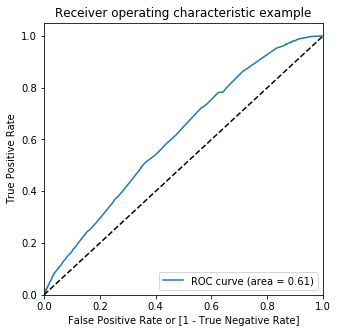

In [95]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

As the ROC curve shows a trade off between True Positive Rate(Sensitivity) and False Positive Rate(1 - Specificity). For a good model the True Positive Rate or Sensitivity should be high and False Positive Rate should be low. 
For a good model the point should be far away from the diagonal. As we can see the curve is far from the diagonal line , test is accurate.

### <span style='color:#0099CC'> Finding Optimal Cutoff Point

This is done to get a balanced sensitivity and specificity.

In [96]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Index_ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.095667,4581,0,1,0,0,0,0,0,0,0,0,0
1,0,0.322580,5109,0,1,1,1,1,0,0,0,0,0,0
2,0,0.479031,4524,0,1,1,1,1,1,0,0,0,0,0
3,0,0.419389,6838,0,1,1,1,1,1,0,0,0,0,0
4,1,0.402359,7760,0,1,1,1,1,1,0,0,0,0,0


In [97]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.369444  1.000000  0.000000
0.1   0.1  0.405370  0.993484  0.060793
0.2   0.2  0.434074  0.974937  0.117181
0.3   0.3  0.443519  0.964912  0.138032
0.4   0.4  0.593519  0.490226  0.654038
0.5   0.5  0.637407  0.079198  0.964464
0.6   0.6  0.633333  0.023058  0.990896
0.7   0.7  0.631481  0.005514  0.998238
0.8   0.8  0.630926  0.001003  1.000000
0.9   0.9  0.630556  0.000000  1.000000


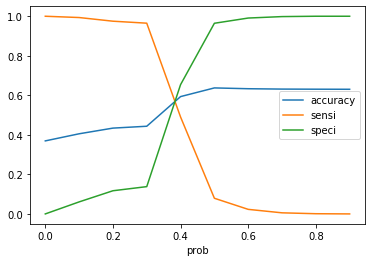

In [98]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

From the above outputs we can infer that the cut off at **0.3** would give better balance between sensitivity and specificity.

In [99]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Index_ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.095667,4581,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.322580,5109,0,1,1,1,1,0,0,0,0,0,0,1
2,0,0.479031,4524,0,1,1,1,1,1,0,0,0,0,0,1
3,0,0.419389,6838,0,1,1,1,1,1,0,0,0,0,0,1
4,1,0.402359,7760,0,1,1,1,1,1,0,0,0,0,0,1


In [100]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.44351851851851853

In [101]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[ 470, 2935],
       [  70, 1925]], dtype=int64)

In [102]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

#### Recall

In [103]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9649122807017544

78.59% of the converted rows are found by the classifier.

In [104]:
# Let us calculate specificity
TN / float(TN+FP)

0.13803230543318648

In [105]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.8619676945668135


#### Precision

In [106]:
# Positive predictive value 
print (TP / float(TP+FP))

0.39609053497942387


65.7% of the converted found by the classifier are truly converted.

In [107]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8703703703703703


# <span style='color:#0099CC'> Predictions on the Test data set

### <span style='color:#0099CC'> Scaling the test data set

As the trained data set is scaled, the model is fit on the scaled data set, so if we don't scale the test data set it will be wrong.Applying the scaling on the test set

As following the golden rule of model evaluation ,Test data set should always be performed on unseen data, Hence only scaler.transform is used, as fit_transform will learn on the data set and then transform.

In [108]:
X_test[continuous_columns].head()

,TotalVisits,Page Views Per Visit
987,1.0,1.0
4907,3.0,3.0
8742,2.0,2.0
3864,4.0,4.0
444,3.0,1.5


In [109]:
continuous_columns

['TotalVisits', 'Page Views Per Visit']

In [110]:
X_test[continuous_columns] = scaling_edu_company_df.transform(X_test[continuous_columns])
X_test[continuous_columns].head()

,TotalVisits,Page Views Per Visit
987,-1.085853,-1.177750
4907,-0.437403,-0.047528
8742,-0.761628,-0.612639
3864,-0.113179,0.517583
444,-0.437403,-0.895195


In [111]:
cols

Index(['Do Not Email', 'TotalVisits', 'Lead Origin_API',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Referral Sites'],
      dtype='object')

In [112]:
X_test = X_test[cols]
X_test.head()

,Do Not Email,TotalVisits,Lead Origin_API,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Referral Sites
987,0,-1.085853,1,0,0,0,0,1
4907,0,-0.437403,0,0,1,0,0,0
8742,0,-0.761628,1,0,1,0,0,0
3864,0,-0.113179,0,0,0,0,1,0
444,0,-0.437403,1,0,0,0,0,1


In [113]:
# Adding constant as we are using statsmodel
X_test_sm = sm.add_constant(X_test)

In [114]:
y_test_pred = model_5.predict(X_test_sm)

In [115]:
y_test_pred[:10]

987     0.189589
4907    0.402624
8742    0.369415
3864    0.394074
444     0.211791
6916    0.345323
627     0.211791
2102    0.487941
1915    0.436071
3925    0.487941
dtype: float64

In [116]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
987,0.189589
4907,0.402624
8742,0.369415
3864,0.394074
444,0.211791


In [117]:
y_test

987     0
4907    0
8742    1
3864    0
444     0
       ..
7198    0
431     0
1357    0
1031    0
7093    0
Name: Converted, Length: 1351, dtype: int64

In [118]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df

,Converted
987,0
4907,0
8742,1
3864,0
444,0
...,...
7198,0
431,0
1357,0
1031,0


In [119]:
# Putting CustID to index
y_test_df['Index_ID'] = y_test_df.index

In [120]:
y_test_df.head()

,Converted,Index_ID
987,0,987
4907,0,4907
8742,1,8742
3864,0,3864
444,0,444


In [121]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [122]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [123]:
y_pred_final.head()

,Converted,Index_ID,0
0,0,987,0.189589
1,0,4907,0.402624
2,1,8742,0.369415
3,0,3864,0.394074
4,0,444,0.211791


In [124]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [125]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Converted,Index_ID,Converted_Prob
0,0,987,0.189589
1,0,4907,0.402624
2,1,8742,0.369415
3,0,3864,0.394074
4,0,444,0.211791


## <span style='color:#0099CC'>Finding the Lead Score

As the business requirement is to build a model wherein, need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. 

This is achieved by using the model's predicted probablity multiplied by 100

In [126]:
y_pred_final['Lead Score'] = round(y_pred_final.Converted_Prob * 100,2)

As we got the optimal cut off at 0.3, predictions of converted are based on this threshold.

In [127]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [128]:
y_pred_final.head()

,Converted,Index_ID,Converted_Prob,Lead Score,final_predicted
0,0,987,0.189589,18.96,0
1,0,4907,0.402624,40.26,1
2,1,8742,0.369415,36.94,1
3,0,3864,0.394074,39.41,1
4,0,444,0.211791,21.18,0


In [129]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.43523316062176165

In [130]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[120, 747],
       [ 16, 468]], dtype=int64)

In [131]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [132]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9669421487603306

79.75% of the converted rows are correctly predicted by the model.

In [133]:
# Let us calculate specificity
TN / float(TN+FP)

0.1384083044982699

73.5% of the not converted rows are correctly predicted by the model.

### <span style='color:#0099cc'> Summary

Test data:<br>
Accuracy: 0.7579570688378978 <br>
sensitivity: 0.7975206611570248 <br>
specificity: 0.7358708189158016 <br>

Train data: <br>
Accuracy: 0.7696296296296297<br>
sensitivity: 0.7859649122807018 <br>
specificity: 0.7600587371512482 <br>

## <span style='color:#0099CC'><u>Business Recommendation:</u></span>
### If the lead score is greater than 30, then the customer has a high chance of getting converted.
